# Reproductive ratio of initial farm $R_i$

- Matt/Mike (2009) farm level reproductive ratio $R_i$ is  $$R_i = \sum_{j \neq i} \text{Prob}_{ij} = \sum_{j \neq i} 1 - \exp(-\text{Rate}_{ij} P). $$
    Where P is the length of infectious period (they assumed to be fixed) and $\text{Prob}_{ij}$ is the probability that farm i infects j over its entire infectious period. 

- Ferguson (2007) defined the relative risk of transmission an infectious farm i would pose to all susceptible farms in the country to be, $$ r_i = \sum_{j \neq i} \text{Rate}_{ij} = (I_c n_{ci} + I_s n_{si}) \left( \sum_{j \neq i} (\frac{s_c}{s_s} n_{cj} + n_{sj})K(d_{ij}) \right) .$$ Then he defined the reproduction number of farm i, $R_{0i}$ to be $r_i$ multiplied by the average duration of the infectiousness of a farm.





- Using Jewell's (2007) rate, which is the rate of transmission to a susceptible farm j, $$ \beta_{j,t} = \nu ( \xi (n_{cj}^\chi + (n_{sj})^\chi ) \left( \sum_{i \in I_t} ( \zeta (n_{ci})^\chi + (n_{si})^\chi ) K(d_{ij}) \right). $$
Then initially (under the assumption only one farm is infectious (farm i)),
$$ \text{Rate}_{ij} = \nu \ ( \ \xi \ (n_{cj}^\chi + (n_{sj})^\chi ) ( \ \zeta \ (n_{ci})^\chi + (n_{si})^\chi ) \  K(d_{ij})$$

In [1]:
import numpy as np
import random as random
import matplotlib.pyplot as plt
import time
import pandas as pd
import multiprocessing
import itertools
from scipy.spatial import distance
from matplotlib import animation

PATH = '../StudyGroup/'

In [2]:
farmData = pd.read_csv(PATH +'Farms_2010_RSG', sep = '\s+', header = None, names = ['County Number', 'Parish Number', 'Holding Number',
                                                                              'X Coordinate', 'Y Coordinate', 'Number of Cattle', 
                                                                              'Number of Sheep'])
cumbData = farmData[farmData['County Number'] == 8]
cumbData = cumbData.reset_index(drop=True)
xCumb = cumbData['X Coordinate']/100000
yCumb = cumbData['Y Coordinate']/100000
xmax = np.max(xCumb)
xmin = np.min(xCumb)
ymax = np.max(yCumb)
ymin = np.min(yCumb)
sizex = xmax-xmin
sizey = ymax-ymin
cattleFrame = cumbData['Number of Cattle']
sheepFrame = cumbData['Number of Sheep']
xcoord = xCumb - xmin #Shift to start from (0, 0)
ycoord = yCumb - ymin #Shift to start from (0, 0)
N=np.size(xcoord)

In [3]:
xinput = xcoord.values
yinput = ycoord.values
joinedinput = np.column_stack((xinput, yinput))
dist = distance.cdist(joinedinput, joinedinput, 'euclidean')

In [4]:
psi = 0.00657
nu = 1.99*(10**(-7))
xi = 2.65
zeta = 1.80
chi = 0.403
s = np.random.negative_binomial(50, 50/55, N) #Draw latent periods
r = np.random.negative_binomial(30, 30/39, N) #Draw infectious periods

t = 0
A = np.zeros(shape=(N,4))
output = np.zeros(shape=(N,6))
mycolumns = ['Farm Number', 'Status', 'Time of Exposure', 'Time of Culling',
                                       'Latent Period', 'Infectious Period', 'X coordinate', 'Y coordinate']
InfectedFarms  = pd.DataFrame(columns =mycolumns)

In [5]:
InfectedFarms['Farm Number']= cumbData.index                                                                                               
InfectedFarms['Status' ] = np.zeros(N)
InfectedFarms['Latent Period'] = s
InfectedFarms['Infectious Period'] = r
InfectedFarms['X coordinate'] = xinput
InfectedFarms['Y coordinate'] = yinput
InfectedFarms[['Time of Exposure', 'Time of Culling']]=[-100,-100]

In [6]:
cattle = abs(cattleFrame.values)
sheep = abs(sheepFrame.values)
K = psi/(psi**2 + dist**2)

K[np.where(dist > 0.2)] = 0

beta1 = np.zeros(N)
beta2 = np.zeros(N)
beta1 = nu*(xi*(cattle)**chi + (sheep)**chi) #susceptible farm
beta2 = (zeta*(cattle)**chi + (sheep)**chi)

# Matt/Mike $R_i$

In [7]:
rate_matrix = np.zeros((N, N))

In [8]:
for j in range(N):
    for i in range(N):
        rate_matrix[i,j] = beta2[i]*beta1[j]*K[i,j]*r[j]

In [9]:
# rate_matrix

In [10]:
A = np.sum(np.ones((N,N))-np.exp(-rate_matrix), axis = 1)

In [11]:
InfectedFarms['R0'] = A

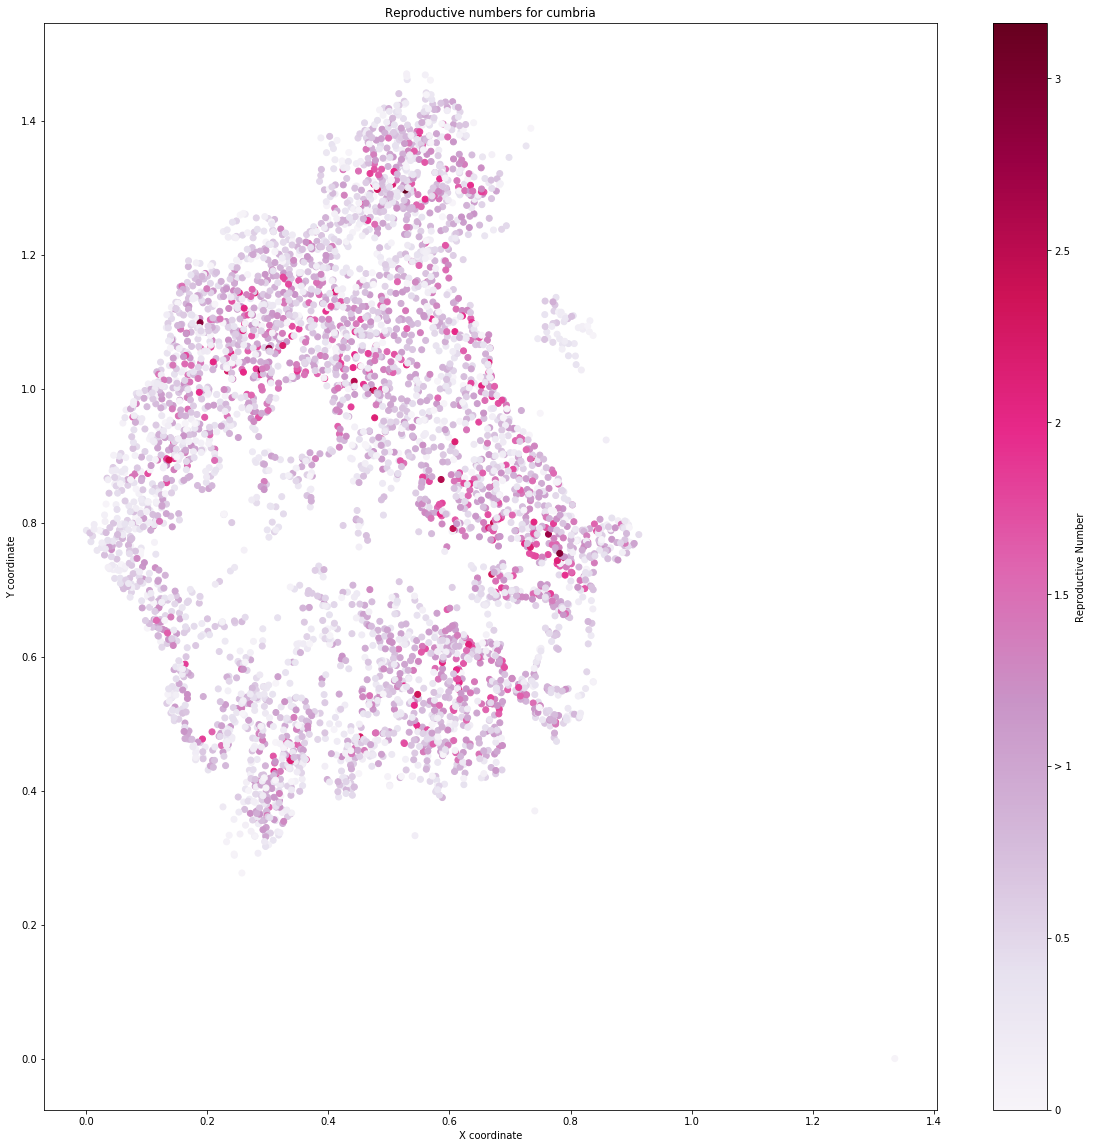

In [12]:
######################### Plots Risk Map #############################
fig = plt.figure(figsize = (20,20))
cax = plt.scatter(InfectedFarms['X coordinate'], InfectedFarms['Y coordinate'],  c=InfectedFarms['R0'], cmap='PuRd')
cbar = fig.colorbar(cax, ticks=[0, 0.5,  1, 1.5,  2, 2.5,  3, 3.5, 4, 4.5], label = 'Reproductive Number')
cbar.ax.set_yticklabels(['0', '0.5', '> 1', '1.5' ,'2', '2.5', '3', '3.5', '4', '4.5'])
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Reproductive numbers for cumbria')
plt.show()

# Ferguson

$$ r_i = \sum_{j \neq i }  Rate_{ij}= ν ( ζ (n_{ci})^\chi+(n_{si})^\chi) \sum_{j \neq i} ( ξ (n_{cj})^\chi+(n_{sj})^\chi) K(dij) $$

Then $$R_0 = r_i \mathbb{E}(\text{period of infectiousness})$$

In [13]:
ferg_rate_matrix = np.zeros((N, N))

In [14]:
for j in range(N):
    for i in range(N):
        ferg_rate_matrix[i,j] = beta2[i]*beta1[j]*K[i,j]

In [15]:
r_i = np.sum(ferg_rate_matrix, axis =1) #Then r_i is the sum of the rows of the rate matrix
period_infec = np.mean(r)
R_0 = r_i*period_infec
InfectedFarms['R0 ferg'] = R_0

Text(0.5,1,'Reproductive numbers for cumbria')

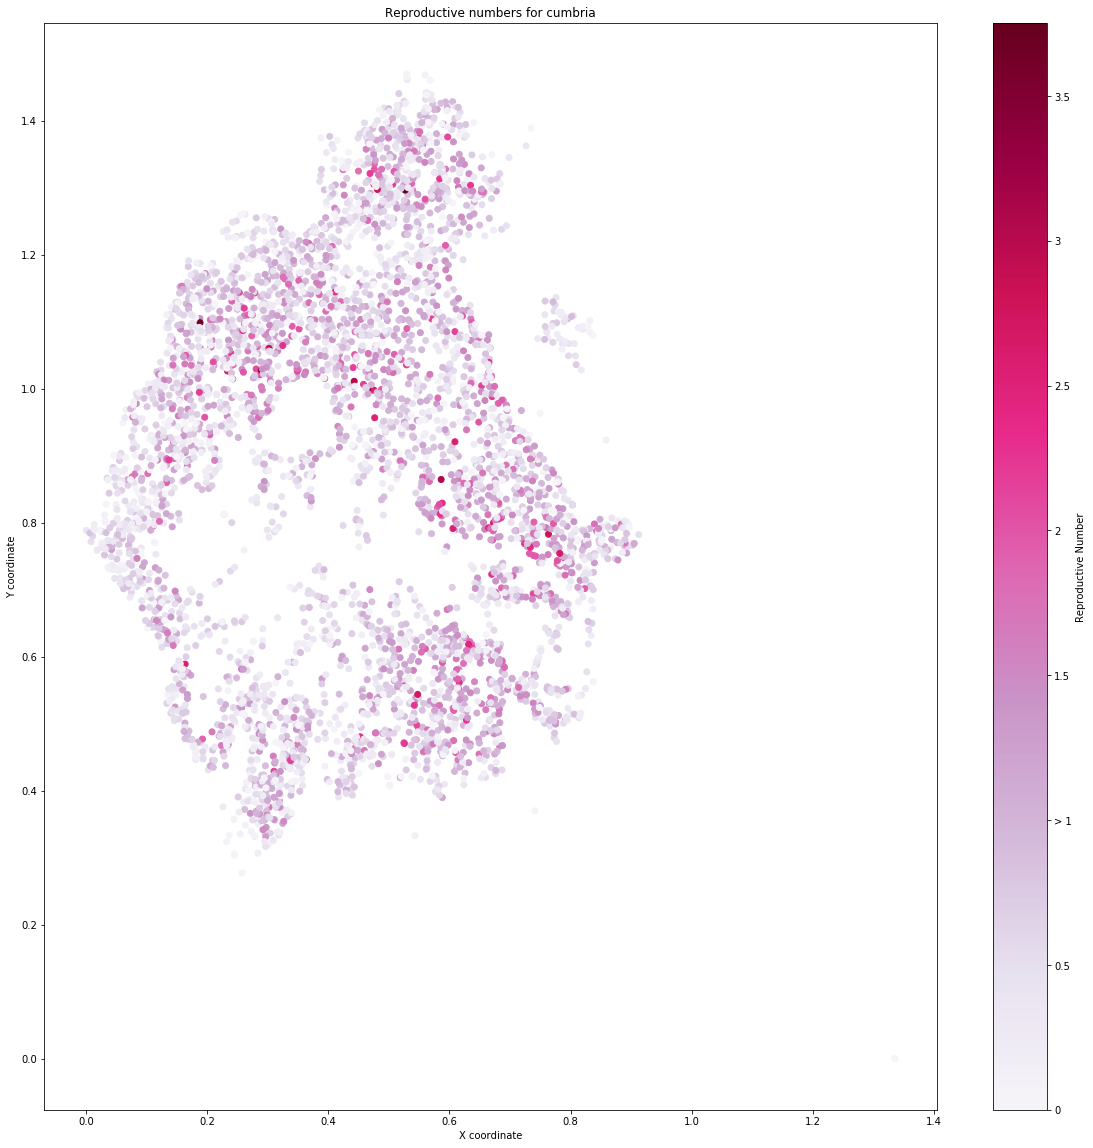

In [16]:
################################## Plots Risk Map ############################
fig = plt.figure(figsize = (20,20))
cax = plt.scatter(InfectedFarms['X coordinate'], InfectedFarms['Y coordinate'],  c=InfectedFarms['R0 ferg'], cmap='PuRd')
cbar = fig.colorbar(cax, ticks=[0, 0.5,  1, 1.5,  2, 2.5,  3, 3.5, 4], label = 'Reproductive Number')
cbar.ax.set_yticklabels(['0', '0.5', '> 1', '1.5' ,'2', '2.5', '3', '3.5', '4', '4.5'])
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title('Reproductive numbers for cumbria')

# Matt/Mike Simulation results
For each farms, perform 10 replicate simulations:
- $E_i$ average number of farms infected or culled
- $P_i^{\text{fail}}$ proportion of replicates that fail to generate more than 10 cases
- $E_i^{\text{success}}$ average number of epidemic impacts that rise to more than 10 cases (i.e exlude $P_i^{\text{fail}}$)

In [17]:
# for farm_index in InfectedFarms['Farm Number']:
#     InfectedFarms.loc[farm_index,['Status', 'Time of Exposure']] =[1,t]
#     start_time = time.time()
#     IP = InfectedFarms['Status']
#     T = 0
#     while sum(IP == 1) + sum(IP == 2) > 0:
#         T = T+1
#     #     print("Day", T, "Exposed", sum(IP == 1), "Infected", sum(IP == 2), "Culled", sum(IP == 3))

#         beta = np.zeros(N)
#         for j in range(N):
#             beta[j] = beta1[j]*(np.sum((zeta*(cattle[IP == 2]**chi) + sheep[IP == 2]**chi)*K[IP == 2, j]))  

#         prob_inf = 1 - np.exp(-beta)
#         unif = np.random.uniform(0, 1, N)
#         for i in range(0,N):
#             if (unif[i] <= prob_inf[i] and IP[i] == 0):
#                 InfectedFarms.loc[i,['Status', 'Time of Exposure']] =[1,T]

#         InfectedFarms.loc[InfectedFarms['Time of Exposure']+InfectedFarms['Latent Period'] == T, 'Status'] =2

#         InfectedFarms.loc[InfectedFarms['Time of Exposure']+
#                           InfectedFarms['Latent Period'] + InfectedFarms['Infectious Period']==T, 'Status'] =3
#     InfectedFarms['Epidemic Impact'] = len(InfectedFarms[InfectedFarms['Time of Exposure']!=-100])
#     InfectedFarms[['Time of Exposure', 'Time of Culling']]=[-100,-100]
#     InfectedFarms['Status' ] = np.zeros(N)    


#     print("--- %s seconds ---" % (time.time() - start_time))

# Include Movements

$$ R_{ij} = 1 - \left(1 - \frac{w_{ij}}{w_i} \right)^{\lambda_i}$$

In [20]:
Movement=pd.read_csv(PATH+'movements_unique', 
                       names = ["From", "To", "Weight"], delim_whitespace=True)
Movement=np.absolute(Movement);
# take movement from CumbNum to CumbNum
CumbNum=cumbData.index.values+1
CumbMoveInt=Movement[Movement['From'].isin(CumbNum)]
CumbMove=CumbMoveInt[CumbMoveInt['To'].isin(CumbNum)]

CumbMoveFrom=CumbMove['From'].values.astype(int)
CumbMoveTo=CumbMove['To'].values.astype(int)
CumbMoveW=CumbMove['Weight'].values

In [24]:
CumbMoveW.reshape((len(cumbData), len(cumbData)))

ValueError: cannot reshape array of size 13734 into shape (4340,4340)

In [43]:
W = np.zeros(shape= (len(cumbData)+1, len(cumbData)+1))

In [44]:
for indexi, i in enumerate(CumbMoveFrom):
        W[i,CumbMoveTo[indexi]] = CumbMoveW[indexi]

In [51]:
max(np.sum(W, axis = 1))

0.25479451929999997

In [49]:
len(CumbMoveFrom)

13734